# Electronic structure

In this exercise, you will combine everything you have learned so far: from Python basics to running and evaluating QE calculations.

### 1. Bandgap of diamond Si

**Tasks**:
Use DFT to calculate the bandgap of Si in the diamond structure. Here are some steps that may guide you:

1. Construct a structure corresponding to diamond Si. Use a primitive cell with two atoms. You can get inspiration from [Materials Project](https://materialsproject.org/materials/mp-149/) and construct `Atoms` object manually, or just use `bulk` from `ase.build`.
2. Get equilibrium (cubic) lattice constant by performing [E-V curve fit](https://en.wikipedia.org/wiki/Birch%E2%80%93Murnaghan_equation_of_state). To spare you convergence tests, you can use plane-wave cut-off energy of $40\,\mathrm{Ry}$ and charge density cutoff energy of $240\,\mathrm{Ry}$ and sample the reciprocal cell (1st Brillouin zone) with automatic $k$-point mesh corresponding to the spacing parameter of $0.03\,\mathrm{Å^{-1}}$. Additionally, add the following parameters to the QE input file:
    - `occupations = 'fixed'` - we have an insulator
    - `nbnd = 10` - for total energy, we care only about the valence band, but for visualization, we want more electrons
(Reasons for this go beyond these exercises. It suffices to say that this is related to the (expected) semiconducting character of Si: [pw.x input file description](https://www.quantum-espresso.org/Doc/INPUT_PW.html))
3. For the equilibrium structure, get a converged electronic structure. To get also the density of states (DOS) and partial density of states (PDOS), we will call QE postprocessing tools dos.x [dos.x input file description](https://www.quantum-espresso.org/Doc/INPUT_DOS.html) and projwfc.x [projwfc.x input file description](https://www.quantum-espresso.org/Doc/INPUT_PROJWFC.html) and parse the DOS information from output text files manually. Get:
    - band gap (Hint: `look for highest occupied, lowest unoccupied level (ev)` line in the `espresso.pwo` output file)
    - plot total density of states (Hint: inspect the `Si.tdos.dat` file (first two columns are the energy and DOS, Fermi level is printed on the header line). Conventionally, zero on the energy axis is set to the Fermi energy
4. Which states ($s$, $p$, ...) are at the top of the valence and the bottom of the conduction band? In which energy range do the $s$ and $p$ states hybridize? (Hint: see `'Si.pdos.pdos_atm#1(Si)_wfc#1(s)'`... files)

We start with loading some useful modules...

In [7]:
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
from ase.eos import EquationOfState
from pyace import PyACECalculator
from ase.io import read

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# We will be using MPI for prallelization, disable OpenMP threading
import os
os.environ['OMP_NUM_THREADS'] = '1'

### 1.1. Optimizing the Si structure

In [8]:
# Si diamond structure primitive cell
diamond_struct = bulk('Si', 'diamond', a=5.431, cubic=True)

We start by gathering the data for equation of state fitting

In [1]:
# QE profile (set how many MPI processes we use, parallelization, and where the pseudopotentials are)
# specifically, we have 4 MPI processes (-np 4) and k-points are distributed over these 4 processes (-nk 4)


volumes = []
energies = []

calc = PyACECalculator('output_potential.yaml')
for scale in tqdm(np.linspace(0.95, 1.05, 11)):
    struct = diamond_struct.copy()
    struct.set_cell(diamond_struct.cell.array*scale, scale_atoms=True)
    # DFT calculations are slow, so first check if the calculation is already done
    # try to read the espresso.pwo output file with ase.io.read
    struct.calc = calc
    energies.append(struct.get_total_energy())
    volumes.append(struct.get_volume())

NameError: name 'PyACECalculator' is not defined

Now, let's fit the Birch-Murnaghan EoS

In [10]:
eos = EquationOfState(volumes, energies, eos="birchmurnaghan")
V0_fit, E0_fit, B0_fit = eos.fit()
a0_fit = (V0_fit*4)**(1/3)
print(f'lattice parameter is {a0_fit:.3f}Å')
print(f'bulk modulus is {B0_fit*160.2:.0f}GPa')
print(f'minimum energy is {E0_fit:.3f}eV')

lattice parameter is 8.627Å
bulk modulus is 71GPa
minimum energy is -15.043eV


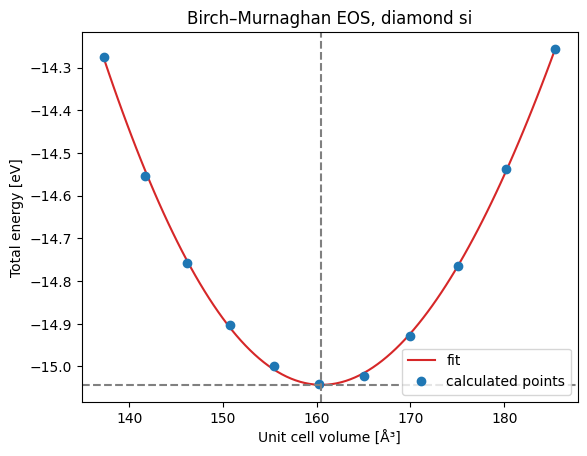

In [11]:
# plot results
from matplotlib import pyplot as plt

ax = eos.plot(show=False) # built-in ASE EOS function to get the matplotlib figure

ax.axvline(V0_fit, ls='--', color='gray')
ax.axhline(E0_fit, ls='--', color='gray')
ax.set_xlabel("Unit cell volume [Å³]")
ax.set_ylabel("Total energy [eV]")
ax.set_title("Birch–Murnaghan EOS, diamond si")
ax.legend(["fit", "calculated points"])

plt.show()